In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, precision_score, recall_score
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

In [3]:
n_mfcc = 40
n_fft = 1024
hop_length = 10 * 16  # 10ms at 16kHz
win_length = 25 * 16  # 25ms at 16kHz
window = 'hann'
sr = 16000

In [4]:
def extract_features(y, sr=16000):
    try:
        # MFCCs and deltas
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Log-mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=n_fft, hop_length=hop_length)
        log_mel = librosa.power_to_db(mel)

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # Statistical features
        features = np.concatenate([
            np.mean(mfcc.T, axis=0), np.std(mfcc.T, axis=0),
            np.mean(delta.T, axis=0), np.std(delta.T, axis=0),
            np.mean(delta2.T, axis=0), np.std(delta2.T, axis=0),
            np.mean(log_mel.T, axis=0), np.std(log_mel.T, axis=0),
            np.mean(chroma.T, axis=0), np.std(chroma.T, axis=0),
            np.mean(spec_contrast.T, axis=0), np.std(spec_contrast.T, axis=0),
            np.mean(tonnetz.T, axis=0), np.std(tonnetz.T, axis=0)
        ])
        return features
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return None

In [5]:
# Function to augment audio
def augment_audio(y, sr=16000):
    augmented = []
    # Noise injection
    y_noise = y + 0.005 * np.random.randn(len(y))
    # Pitch shift
    y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-2, 3))
    # Time stretch
    y_stretch = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
    # Volume perturbation
    y_volume = y * np.random.uniform(0.8, 1.2)
    augmented.extend([y_noise, y_shift, y_stretch, y_volume])
    return augmented

In [6]:
def plot_audio(y, sr, label, file_name):
    plt.figure(figsize=(12, 6))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {label} ({file_name})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {label} ({file_name})')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

In [7]:
# Define path to data directory
path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/donateacry_corpus'

# Load and augment data
features = []
labels = []
label_names = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
target_per_class = 100  # Target number of samples per class

In [8]:
for label in os.listdir(path):
    if not os.path.isdir(os.path.join(path, label)):
        continue
    print(f"Loading and augmenting {label} data...")
    label_path = os.path.join(path, label)
    original_files = os.listdir(label_path)
    num_files = len(original_files)
    plotted = 0  # Limit number of plots per class

    for file_name in original_files:
        file_path = os.path.join(label_path, file_name)
        y, sr = librosa.load(file_path, sr=16000)

        # Plot waveform and spectrogram for first few files
        if plotted < 2:  # Plot for up to 2 files per class
            plot_audio(y, sr, label, file_name)
            plotted += 1

        feature = extract_features(y, sr)
        if feature is not None:
            features.append(feature)
            labels.append(label)

        # Augment minority classes
        if label != 'hungry' and num_files < target_per_class:
            augmented_ys = augment_audio(y, sr)
            for aug_y in augmented_ys:
                aug_feature = extract_features(aug_y, sr)
                if aug_feature is not None:
                    features.append(aug_feature)
                    labels.append(label)

    # Limit augmentation to target_per_class
    if label != 'hungry':
        current_count = sum(1 for l in labels if l == label)
        while current_count < target_per_class:
            y, sr = librosa.load(os.path.join(label_path, original_files[np.random.randint(num_files)]), sr=16000)
            aug_y = augment_audio(y, sr)[np.random.randint(4)]
            aug_feature = extract_features(aug_y, sr)
            if aug_feature is not None:
                features.append(aug_feature)
                labels.append(label)
                current_count += 1

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Print class distribution
for label in os.listdir(path):
    class_path = os.path.join(path, label)
    if os.path.isdir(class_path):
        num_samples = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"Class: {label}, Number of samples: {num_samples}")

Class: burping, Number of samples: 8
Class: discomfort, Number of samples: 27
Class: hungry, Number of samples: 382
Class: belly_pain, Number of samples: 16
Class: tired, Number of samples: 24


In [10]:
# Downsample 'hungry' to balance
hungry_idx = [i for i, l in enumerate(labels) if l == 'hungry']
other_idx = [i for i, l in enumerate(labels) if l != 'hungry']
hungry_features = np.array(features)[hungry_idx]
hungry_labels = np.array(labels)[hungry_idx]
hungry_features_downsampled, hungry_labels_downsampled = resample(
    hungry_features, hungry_labels, n_samples=target_per_class, random_state=42
)
features_balanced = np.vstack([hungry_features_downsampled, np.array(features)[other_idx]])
labels_balanced = np.hstack([hungry_labels_downsampled, np.array(labels)[other_idx]])

In [11]:
# Convert to numpy arrays
features = np.array(features_balanced)
labels = np.array(labels_balanced)

In [12]:
# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [13]:
# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [14]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
features = pca.fit_transform(features)
print(f"Reduced feature dimension: {features.shape[1]}")

Reduced feature dimension: 76


In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

In [16]:
# Plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training accuracy')
    plt.plot(train_sizes, test_mean, label='Validation accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [17]:
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
                       rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_
print("Best RF Parameters:", rf_grid.best_params_)

# Train and evaluate Random Forest
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')
rf_precision = precision_score(y_test, rf_pred, average='macro')
rf_recall = recall_score(y_test, rf_pred, average='macro')
print("\nRandom Forest Accuracy:", rf_acc)
print("Random Forest F1 Score:", rf_f1)
print("RF Classification Report:\n", classification_report(y_test, rf_pred, target_names=label_names))

Best RF Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest Accuracy: 0.7657657657657657
Random Forest F1 Score: 0.7444738921209509
RF Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.82      0.90      0.86        20
     burping       0.85      0.85      0.85        20
  discomfort       0.64      0.85      0.73        27
      hungry       1.00      0.30      0.46        20
       tired       0.78      0.88      0.82        24

    accuracy                           0.77       111
   macro avg       0.82      0.76      0.74       111
weighted avg       0.80      0.77      0.75       111



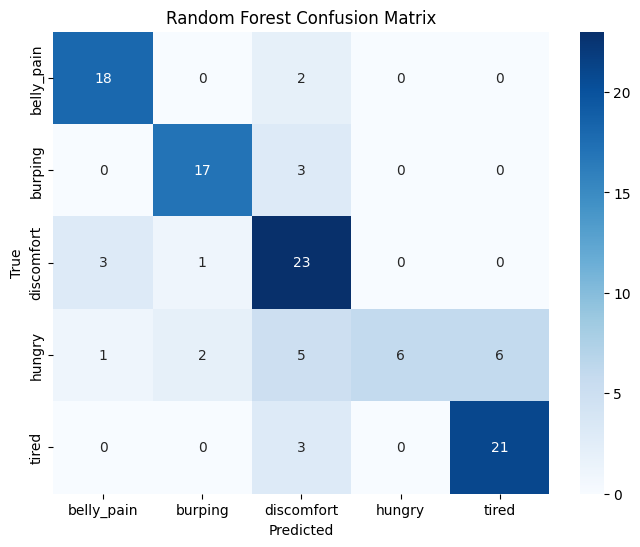

In [18]:
# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

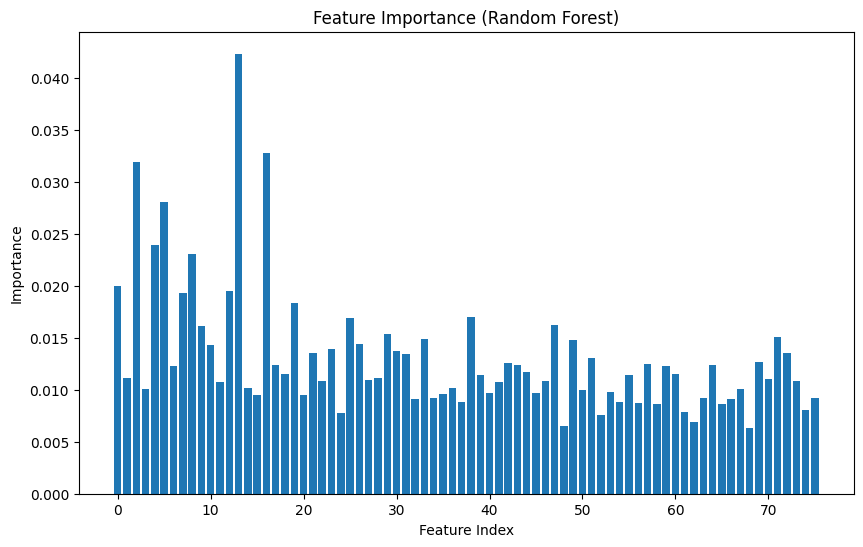

In [19]:
# Feature Importance for Random Forest
feature_importance = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [20]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(subsample=0.8, colsample_bytree=0.8, random_state=42),
                        xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_clf = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Train and evaluate XGBoost
xgb_clf.fit(X_train, y_train, sample_weight=[class_weight_dict[label] for label in y_train])
xgb_pred = xgb_clf.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
xgb_precision = precision_score(y_test, xgb_pred, average='macro')
xgb_recall = recall_score(y_test, xgb_pred, average='macro')
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost F1 Score:", xgb_f1)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred, target_names=label_names))

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Accuracy: 0.7657657657657657
XGBoost F1 Score: 0.7632805591213806
XGBoost Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.94      0.85      0.89        20
     burping       0.81      0.85      0.83        20
  discomfort       0.70      0.78      0.74        27
      hungry       0.62      0.50      0.56        20
       tired       0.77      0.83      0.80        24

    accuracy                           0.77       111
   macro avg       0.77      0.76      0.76       111
weighted avg       0.77      0.77      0.76       111



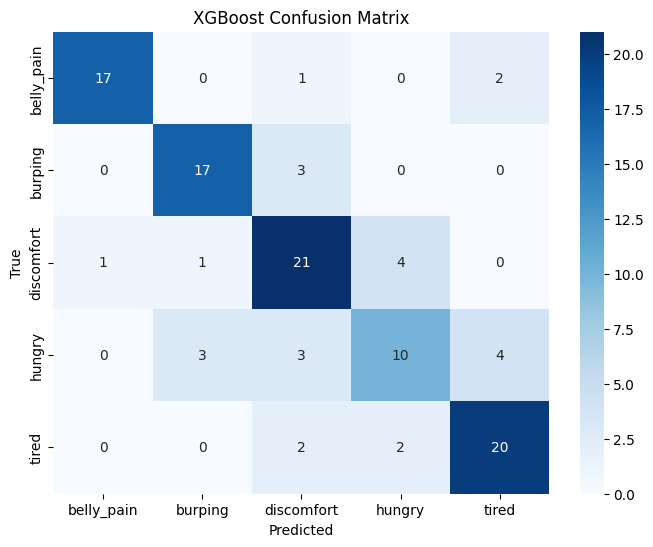

In [21]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [22]:
# Simple Neural Network
def create_nn_model(input_dim, num_classes):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
nn_model = create_nn_model(features.shape[1], len(label_names))
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
nn_pred = np.argmax(nn_model.predict(X_test), axis=1)
nn_acc = accuracy_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred, average='macro')
nn_precision = precision_score(y_test, nn_pred, average='macro')
nn_recall = recall_score(y_test, nn_pred, average='macro')
print("\nNeural Network Accuracy:", nn_acc)
print("Neural Network F1 Score:", nn_f1)
print("Neural Network Classification Report:\n", classification_report(y_test, nn_pred, target_names=label_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Neural Network Accuracy: 0.8198198198198198
Neural Network F1 Score: 0.8113881416872673
Neural Network Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.94      0.80      0.86        20
     burping       0.86      0.90      0.88        20
  discomfort       0.86      0.89      0.87        27
      hungry       0.69      0.55      0.61        20
       tired       0.76      0.92      0.83        24

    accuracy                           0.82       111
   macro avg       0.82      0.81      0.81       111
weighted avg       0.82      0.82      0.82       111



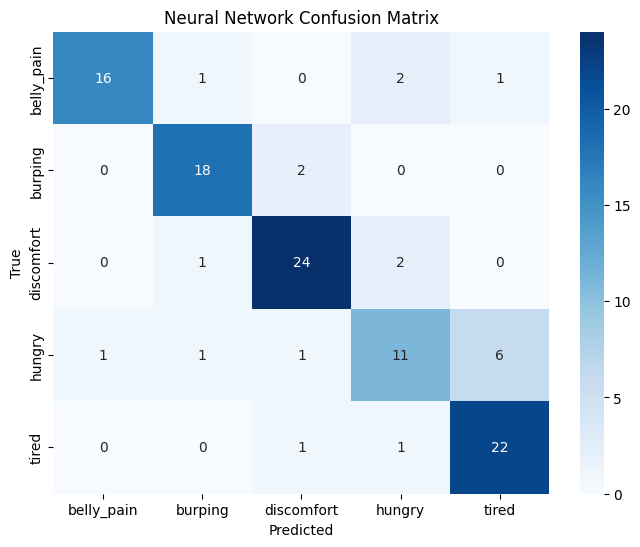

In [23]:
# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, nn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()

In [24]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Define base estimators for stacking
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', xgb.XGBClassifier(subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ]

# Initialize StackingClassifier with defined estimators
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42), cv=5)
stacking_clf.fit(X_train, y_train)
stack_pred = stacking_clf.predict(X_test)
stack_acc = accuracy_score(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred, average='macro')
stack_precision = precision_score(y_test, stack_pred, average='macro')
stack_recall = recall_score(y_test, stack_pred, average='macro')
print("\nStacking Ensemble Accuracy:", stack_acc)
print("Stacking Ensemble F1 Score:", stack_f1)
print("Stacking Classification Report:\n", classification_report(y_test, stack_pred, target_names=label_names))


Stacking Ensemble Accuracy: 0.8108108108108109
Stacking Ensemble F1 Score: 0.8119691119691119
Stacking Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.85      0.85      0.85        20
     burping       0.90      0.90      0.90        20
  discomfort       0.72      0.78      0.75        27
      hungry       0.76      0.65      0.70        20
       tired       0.84      0.88      0.86        24

    accuracy                           0.81       111
   macro avg       0.82      0.81      0.81       111
weighted avg       0.81      0.81      0.81       111



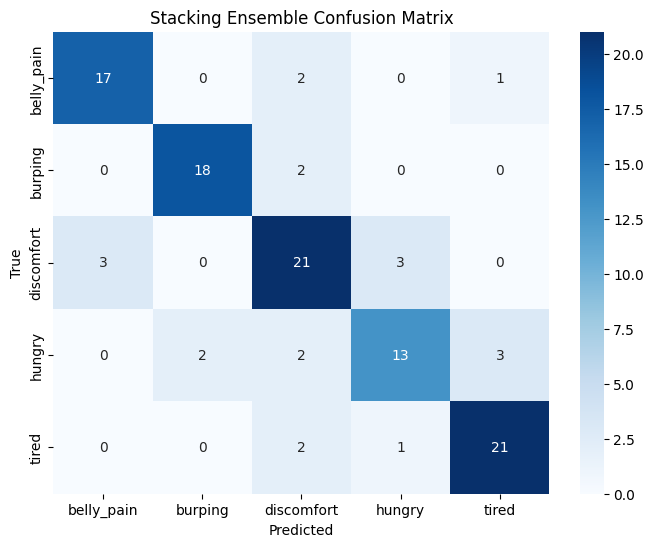

In [25]:
# Confusion Matrix for Stacking
cm_stack = confusion_matrix(y_test, stack_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stack, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stacking Ensemble Confusion Matrix')
plt.show()

In [26]:

from tensorflow.keras.layers import LSTM

# LSTM Model
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Reshape data for LSTM (assuming a time series of features)
timesteps = 1 # You need to define an appropriate timestep for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

lstm_model = create_lstm_model((timesteps, features.shape[1]), len(label_names))
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

lstm_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
lstm_acc = accuracy_score(y_test, lstm_pred)
lstm_f1 = f1_score(y_test, lstm_pred, average='macro')
lstm_precision = precision_score(y_test, lstm_pred, average='macro')
lstm_recall = recall_score(y_test, lstm_pred, average='macro')

print("\nLSTM Accuracy:", lstm_acc)
print("LSTM F1 Score:", lstm_f1)
print("LSTM Classification Report:\n", classification_report(y_test, lstm_pred, target_names=label_names))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step

LSTM Accuracy: 0.8018018018018018
LSTM F1 Score: 0.8031693912043659
LSTM Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      0.85      0.92        20
     burping       0.86      0.90      0.88        20
  discomfort       0.78      0.78      0.78        27
      hungry       0.71      0.60      0.65        20
       tired       0.72      0.88      0.79        24

    accuracy                           0.80       111
   macro avg       0.81      0.80      0.80       111
weighted avg       0.81      0.80      0.80       111



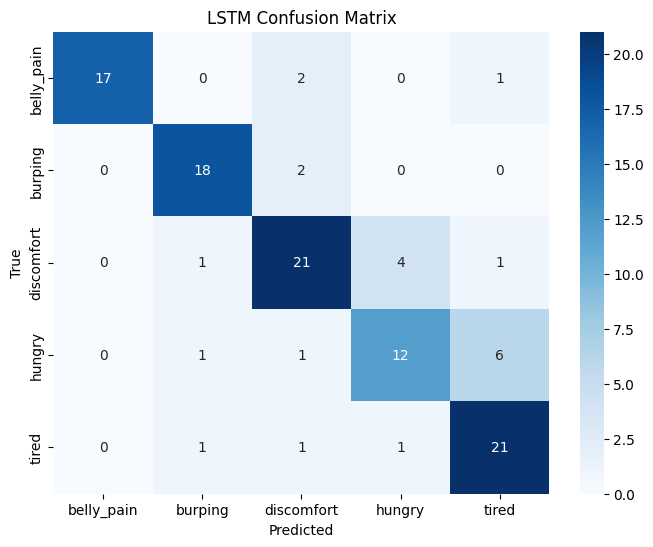

In [27]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, lstm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()

In [28]:
# Cross-Validation Scores with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf, features, labels, cv=skf, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_clf, features, labels, cv=skf, scoring='accuracy')
stack_cv_scores = cross_val_score(stacking_clf, features, labels, cv=skf, scoring='accuracy')
print("\nRF Cross-Validation Accuracy:", rf_cv_scores.mean(), "±", rf_cv_scores.std())
print("XGBoost Cross-Validation Accuracy:", xgb_cv_scores.mean(), "±", xgb_cv_scores.std())
print("Stacking Cross-Validation Accuracy:", stack_cv_scores.mean(), "±", stack_cv_scores.std())


RF Cross-Validation Accuracy: 0.8108108108108109 ± 0.034186785515333815
XGBoost Cross-Validation Accuracy: 0.8108108108108109 ± 0.022791190343555884
Stacking Cross-Validation Accuracy: 0.7657657657657658 ± 0.02672503959313753


In [29]:
# Summary of Model Performance
print("\n--- Model Performance Summary ---")
print(f"Random Forest: Accuracy={rf_acc:.4f}, F1={rf_f1:.4f}")
print(f"XGBoost: Accuracy={xgb_acc:.4f}, F1={xgb_f1:.4f}")
print(f"Neural Network: Accuracy={nn_acc:.4f}, F1={nn_f1:.4f}")
print(f"Stacking Ensemble: Accuracy={stack_acc:.4f}, F1={stack_f1:.4f}")
print(f"LSTM: Accuracy={lstm_acc:.4f}, F1={lstm_f1:.4f}")



--- Model Performance Summary ---
Random Forest: Accuracy=0.7658, F1=0.7445
XGBoost: Accuracy=0.7658, F1=0.7633
Neural Network: Accuracy=0.8198, F1=0.8114
Stacking Ensemble: Accuracy=0.8108, F1=0.8120
LSTM: Accuracy=0.8018, F1=0.8032


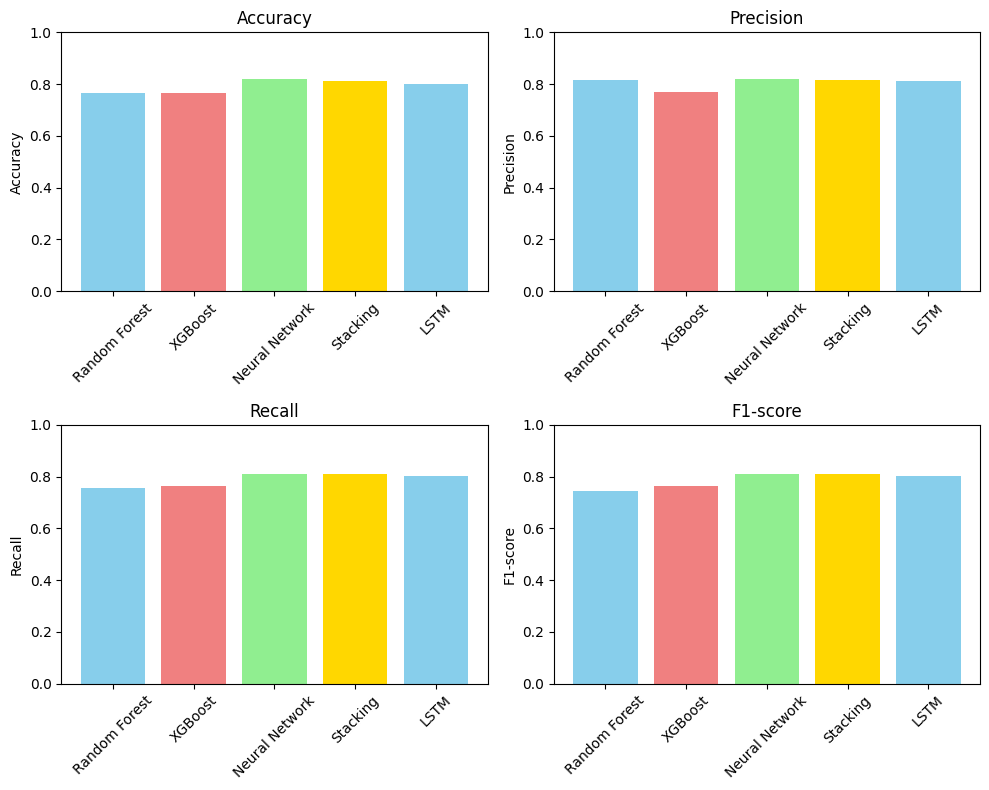

In [32]:
models = ['Random Forest', 'XGBoost', 'Neural Network', 'Stacking','LSTM']
accuracies = [rf_acc, xgb_acc, nn_acc, stack_acc,lstm_acc]
precisions = [rf_precision, xgb_precision, nn_precision, stack_precision,lstm_precision]
recalls = [rf_recall, xgb_recall, nn_recall, stack_recall,lstm_recall]
f1_scores = [rf_f1, xgb_f1, nn_f1, stack_f1,lstm_f1]

metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
axes = axes.flatten()

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    axes[i].bar(models, metric, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[i].set_title(metric_name)
    axes[i].set_ylabel(metric_name)
    axes[i].set_ylim(0, 1.0) # Adjust y-axis limit as needed
    axes[i].tick_params(axis='x', rotation=45)

plt.show()


Testing audio file: /content/drive/MyDrive/Projectss/Baby Cry Detection/tired_test_audio.wav


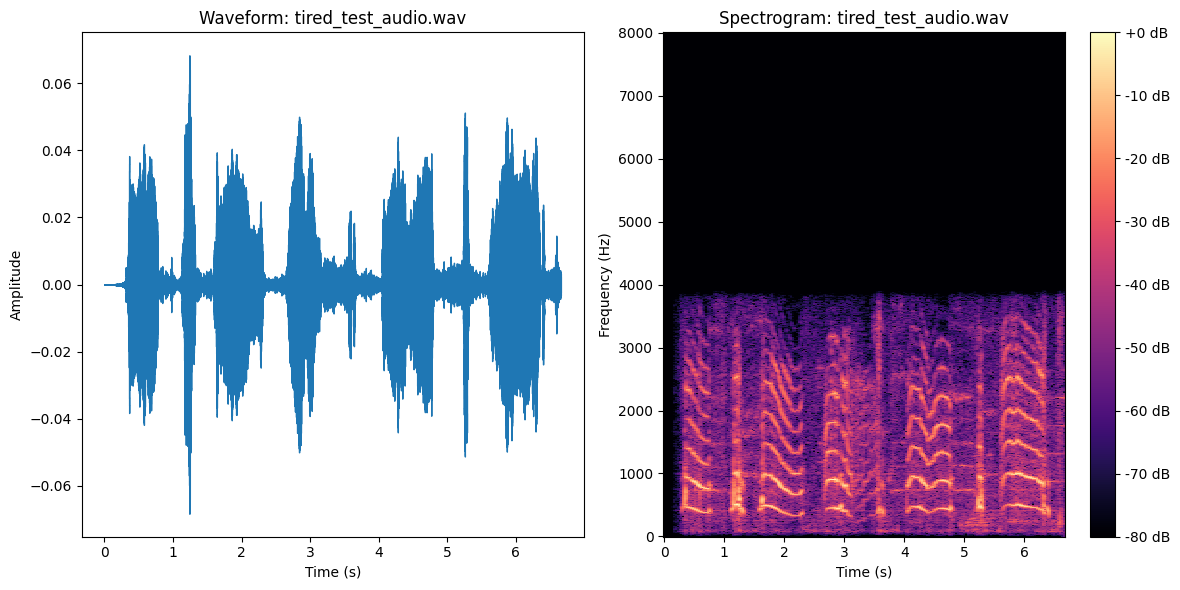


Random Forest Prediction:
Class: tired
Confidence: 0.7843
Class Probabilities:
  belly_pain: 0.0309
  burping: 0.0655
  discomfort: 0.0595
  hungry: 0.0598
  tired: 0.7843

XGBoost Prediction:
Class: tired
Confidence: 0.9945
Class Probabilities:
  belly_pain: 0.0011
  burping: 0.0010
  discomfort: 0.0015
  hungry: 0.0019
  tired: 0.9945

Neural Network Prediction:
Class: tired
Confidence: 0.9999
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0000
  discomfort: 0.0000
  hungry: 0.0000
  tired: 0.9999

Stacking Ensemble Prediction:
Class: tired
Confidence: 0.9700
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0000
  discomfort: 0.0300
  hungry: 0.0000
  tired: 0.9700

LSTM Prediction:
Class: tired
Confidence: 0.9988
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0001
  discomfort: 0.0003
  hungry: 0.0008
  tired: 0.9988


In [44]:
# Function to test a single audio file
def test_audio_file(file_path, scaler, pca, le, rf_model, xgb_model, nn_model, stack_model, lstm_model, sr=16000):
    print(f"\nTesting audio file: {file_path}")

    # Load audio
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return

    # Plot waveform and spectrogram
    plt.figure(figsize=(12, 6))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {os.path.basename(file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

    # Extract features (using the same function as training)
    feature = extract_features(y, sr)
    if feature is None:
        print("Feature extraction failed.")
        return

    # Reshape and preprocess
    feature = feature.reshape(1, -1)
    feature = scaler.transform(feature)  # Normalize
    feature = pca.transform(feature)     # Apply PCA

    # Predict with each model
    models = {
        'Random Forest': rf_model,
        'XGBoost': xgb_model,
        'Neural Network': nn_model,
        'Stacking Ensemble': stack_model,
        'LSTM': lstm_model  # Add LSTM to the models dictionary
    }

    for name, model in models.items():
        if name == 'Neural Network' or name == 'LSTM':  # Handle NN and LSTM
            if name == 'LSTM':
                feature_input = feature.reshape(1, 1, -1)  # Reshape for LSTM
            else:
                feature_input = feature
            pred_proba = model.predict(feature_input, verbose=0)
            pred = np.argmax(pred_proba, axis=1)
            confidence = np.max(pred_proba)
        else:
            pred = model.predict(feature)
            pred_proba = model.predict_proba(feature)
            confidence = np.max(pred_proba)

        pred_label = le.inverse_transform(pred)[0]
        print(f"\n{name} Prediction:")
        print(f"Class: {pred_label}")
        print(f"Confidence: {confidence:.4f}")
        print("Class Probabilities:")
        for label, prob in zip(le.classes_, pred_proba[0]):
            print(f"  {label}: {prob:.4f}")

# Specify the test audio file path
test_file_path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/tired_test_audio.wav'  # Update this path

# Test the audio file
test_audio_file(test_file_path, scaler, pca, le, rf, xgb_clf, nn_model, stacking_clf, lstm_model, sr=16000)



Testing audio file: /content/drive/MyDrive/Projectss/Baby Cry Detection/belly_pain_test_audio.wav


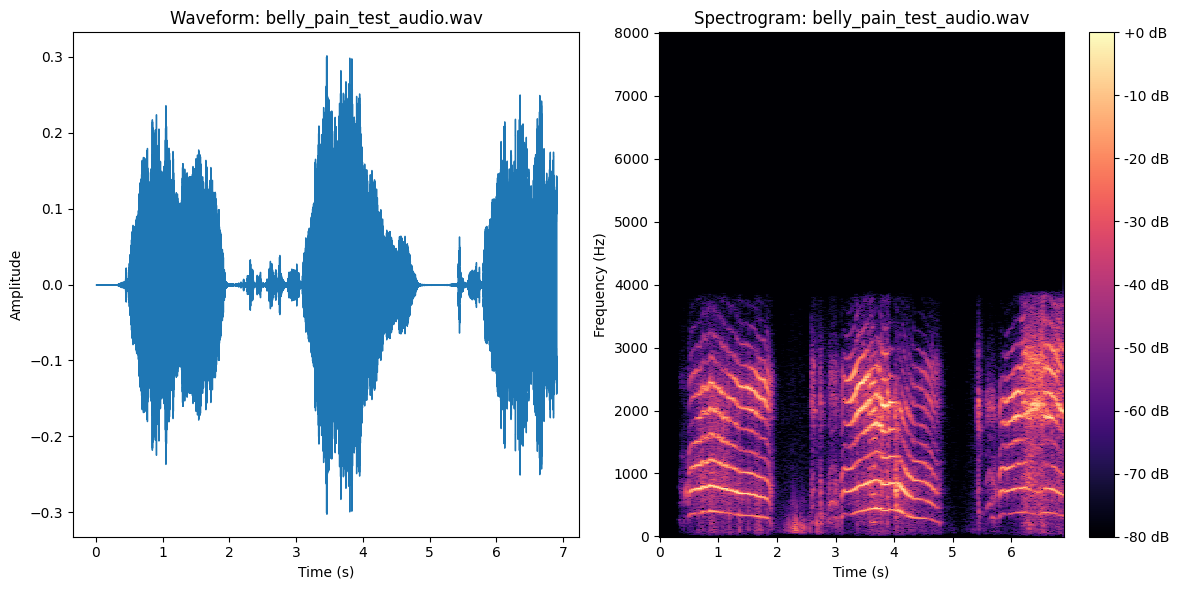


Random Forest Prediction:
Class: belly_pain
Confidence: 0.8684
Class Probabilities:
  belly_pain: 0.8684
  burping: 0.0233
  discomfort: 0.0463
  hungry: 0.0186
  tired: 0.0434

XGBoost Prediction:
Class: belly_pain
Confidence: 0.9914
Class Probabilities:
  belly_pain: 0.9914
  burping: 0.0021
  discomfort: 0.0011
  hungry: 0.0012
  tired: 0.0041

Neural Network Prediction:
Class: belly_pain
Confidence: 0.9999
Class Probabilities:
  belly_pain: 0.9999
  burping: 0.0000
  discomfort: 0.0000
  hungry: 0.0000
  tired: 0.0000

Stacking Ensemble Prediction:
Class: belly_pain
Confidence: 1.0000
Class Probabilities:
  belly_pain: 1.0000
  burping: 0.0000
  discomfort: 0.0000
  hungry: 0.0000
  tired: 0.0000

LSTM Prediction:
Class: belly_pain
Confidence: 0.9986
Class Probabilities:
  belly_pain: 0.9986
  burping: 0.0001
  discomfort: 0.0012
  hungry: 0.0001
  tired: 0.0001


In [49]:
# Specify the test audio file path
test_file_path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/belly_pain_test_audio.wav'  # Update this path

# Test the audio file
test_audio_file(test_file_path, scaler, pca, le, rf, xgb_clf, nn_model, stacking_clf, lstm_model, sr=16000)


Testing audio file: /content/drive/MyDrive/Projectss/Baby Cry Detection/hungry_test_audio.wav


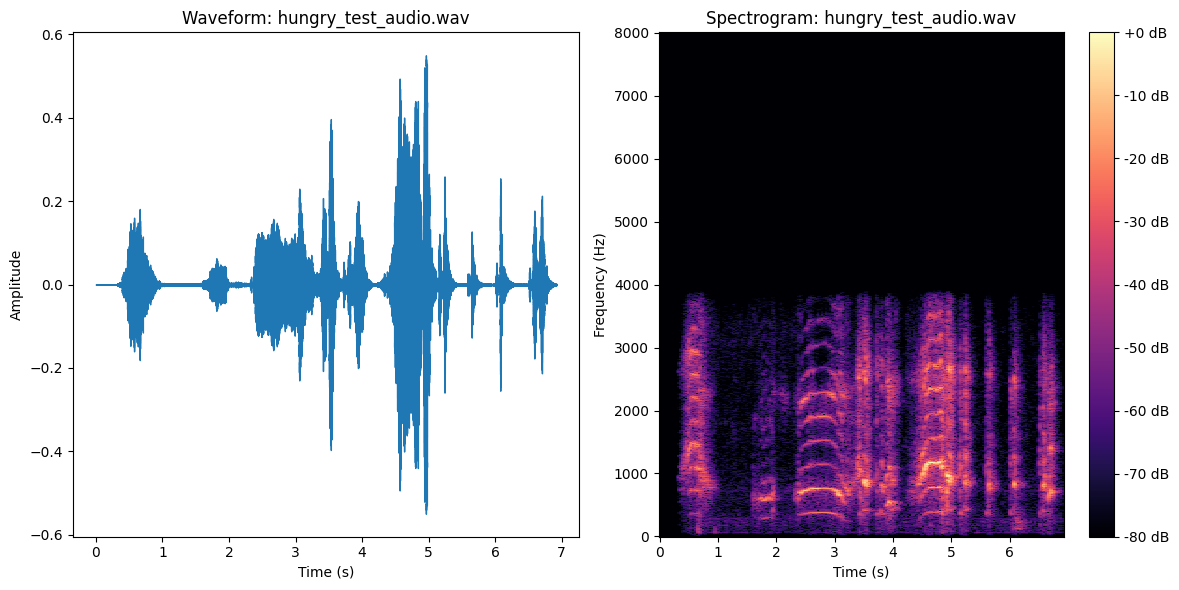


Random Forest Prediction:
Class: discomfort
Confidence: 0.3256
Class Probabilities:
  belly_pain: 0.0970
  burping: 0.1045
  discomfort: 0.3256
  hungry: 0.2096
  tired: 0.2632

XGBoost Prediction:
Class: discomfort
Confidence: 0.6673
Class Probabilities:
  belly_pain: 0.0219
  burping: 0.0071
  discomfort: 0.6673
  hungry: 0.2478
  tired: 0.0559

Neural Network Prediction:
Class: hungry
Confidence: 0.9986
Class Probabilities:
  belly_pain: 0.0001
  burping: 0.0000
  discomfort: 0.0005
  hungry: 0.9986
  tired: 0.0007

Stacking Ensemble Prediction:
Class: discomfort
Confidence: 0.3400
Class Probabilities:
  belly_pain: 0.0100
  burping: 0.0000
  discomfort: 0.3400
  hungry: 0.3100
  tired: 0.3400

LSTM Prediction:
Class: hungry
Confidence: 0.9924
Class Probabilities:
  belly_pain: 0.0001
  burping: 0.0002
  discomfort: 0.0046
  hungry: 0.9924
  tired: 0.0027


In [46]:
# Specify the test audio file path
test_file_path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/hungry_test_audio.wav'  # Update this path

# Test the audio file
test_audio_file(test_file_path, scaler, pca, le, rf, xgb_clf, nn_model, stacking_clf, lstm_model, sr=16000)


Testing audio file: /content/drive/MyDrive/Projectss/Baby Cry Detection/discomfort_test_audio.wav


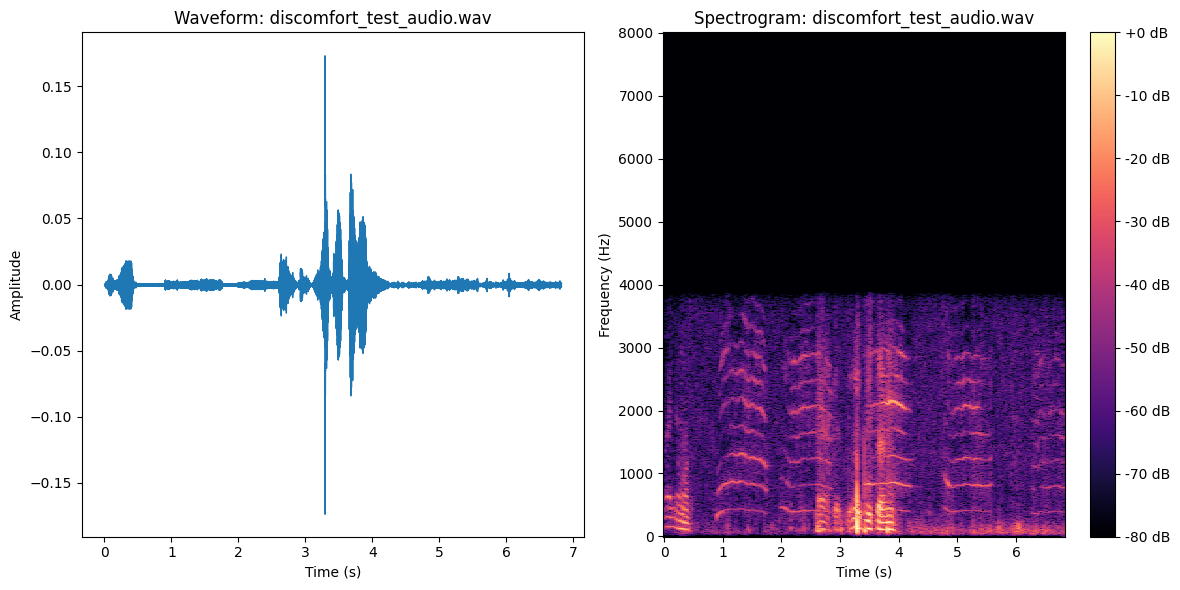


Random Forest Prediction:
Class: discomfort
Confidence: 0.7828
Class Probabilities:
  belly_pain: 0.0389
  burping: 0.0206
  discomfort: 0.7828
  hungry: 0.0372
  tired: 0.1205

XGBoost Prediction:
Class: discomfort
Confidence: 0.9925
Class Probabilities:
  belly_pain: 0.0012
  burping: 0.0016
  discomfort: 0.9925
  hungry: 0.0030
  tired: 0.0017

Neural Network Prediction:
Class: discomfort
Confidence: 1.0000
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0000
  discomfort: 1.0000
  hungry: 0.0000
  tired: 0.0000

Stacking Ensemble Prediction:
Class: discomfort
Confidence: 0.9800
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0000
  discomfort: 0.9800
  hungry: 0.0000
  tired: 0.0200

LSTM Prediction:
Class: discomfort
Confidence: 0.9989
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.0000
  discomfort: 0.9989
  hungry: 0.0010
  tired: 0.0001


In [47]:
# Specify the test audio file path
test_file_path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/discomfort_test_audio.wav'  # Update this path

# Test the audio file
test_audio_file(test_file_path, scaler, pca, le, rf, xgb_clf, nn_model, stacking_clf, lstm_model, sr=16000)


Testing audio file: /content/drive/MyDrive/Projectss/Baby Cry Detection/burping_test_audio.wav


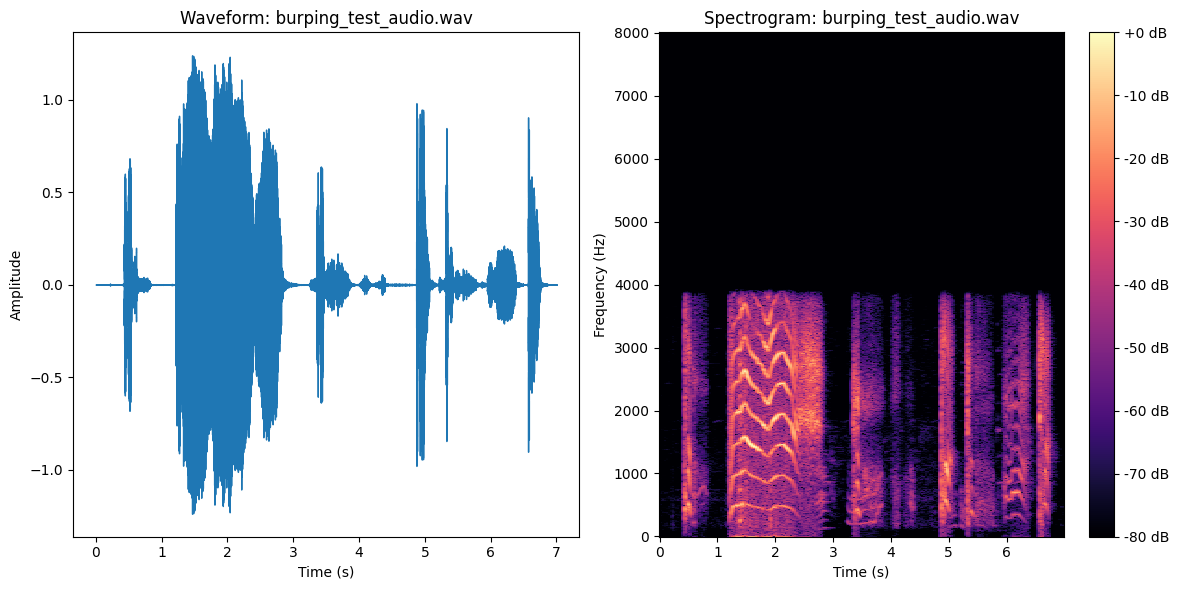


Random Forest Prediction:
Class: burping
Confidence: 0.9405
Class Probabilities:
  belly_pain: 0.0040
  burping: 0.9405
  discomfort: 0.0124
  hungry: 0.0175
  tired: 0.0256

XGBoost Prediction:
Class: burping
Confidence: 0.9967
Class Probabilities:
  belly_pain: 0.0011
  burping: 0.9967
  discomfort: 0.0008
  hungry: 0.0006
  tired: 0.0007

Neural Network Prediction:
Class: burping
Confidence: 1.0000
Class Probabilities:
  belly_pain: 0.0000
  burping: 1.0000
  discomfort: 0.0000
  hungry: 0.0000
  tired: 0.0000

Stacking Ensemble Prediction:
Class: burping
Confidence: 1.0000
Class Probabilities:
  belly_pain: 0.0000
  burping: 1.0000
  discomfort: 0.0000
  hungry: 0.0000
  tired: 0.0000

LSTM Prediction:
Class: burping
Confidence: 0.9996
Class Probabilities:
  belly_pain: 0.0000
  burping: 0.9996
  discomfort: 0.0002
  hungry: 0.0001
  tired: 0.0001


In [48]:
# Specify the test audio file path
test_file_path = '/content/drive/MyDrive/Projectss/Baby Cry Detection/burping_test_audio.wav'  # Update this path

# Test the audio file
test_audio_file(test_file_path, scaler, pca, le, rf, xgb_clf, nn_model, stacking_clf, lstm_model, sr=16000)